In [36]:
import requests
import cv2
from matplotlib import pyplot as plt
import numpy as np
from numpy import inf
from math import pi, log, tan, floor, exp, atan
import decimal
from statistics import mode, mean
from random import uniform
from math import cos, sin, sqrt
import pandas as pd
import random

decimal.getcontext().prec = 20
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

In [2]:
x = 206988
y = 129893
x_Desaru = 206988
y_Desaru = 129893
x_BtBl = 214903
y_BtBl = 137399
x_false = 214907
y_false = 137399
gis_ls = []

In [3]:
def latlong_to_ordinates(latitude_longitude):

    # 18 is the zoom level 
    mapWidth    = pow(2,18)
    mapHeight   = pow(2,18)
    x = (latitude_longitude[1]+180)*(mapWidth/360)
    latRad = latitude_longitude[0]*pi/180
    mercN = log(tan((pi/4)+(latRad/2)))
    y = (mapHeight/2)-(mapWidth*mercN/(2*pi))
    
    return (floor(x),floor(y))

In [4]:
def ordinates_to_latlong(x_y):

    # 18 is the zoom level 
    mapWidth    = pow(2,18)
    mapHeight   = pow(2,18)
    longitude = x_y[0]/(mapWidth/360) - 180
    latitude = (atan(exp(((mapHeight/2) - x_y[1] ) * (2*pi) / mapWidth)) - (pi/4))*2/pi*180
    
    return (latitude, longitude)

In [5]:
def get_random_point_on_oval(lat1,long1,lat2,long2):
    x1,y1 = latlong_to_ordinates((lat1, long1))
    x2,y2 = latlong_to_ordinates((lat2, long2))
    w = x2-x1
    h = y2-y1
    x_c = (x1+x2)/2
    y_c = (y1+y2)/2
    θ = uniform(0,2*pi)
    l = uniform(sqrt((h*h*w*w)/(4*h*h*cos(θ)*cos(θ) + 4*w*w*sin(θ)*sin(θ)))*0.5,sqrt((h*h*w*w)/(4*h*h*cos(θ)*cos(θ) + 4*w*w*sin(θ)*sin(θ))))
    x_r = int(cos(θ)*l + x_c)
    y_r = int(sin(θ)*l + y_c)
    (lat,long) = ordinates_to_latlong((x_r,y_r))
    print('https://www.google.com/maps?z=16&t=k&q='+str(lat)+','+str(long))
    return (x_r,y_r)

In [215]:
def Get_Coast_Line(x,y,sensitivity,kernel_size,sobel_ksize,kernel_size_2):
    
    # Get Image according to x and y
    url = 'https://khms1.google.com/kh/v=941?x='+str(x)+'&y='+str(y)+'&z='+str(6) 
    '''
    pac = get_pac(url='http://pac.nomura.com/sinproxy.pac')
    st = PACSession(pac)
    '''
    response = requests.get(url, stream=True, headers = headers)
    path = open('images/'+str(x)+'-'+str(y)+'.png', 'wb')
    path.write(response.content)
    path.close()
    
    img = cv2.imread('images/'+str(x)+'-'+str(y)+'.png')
    img_org = img.copy()
    
    # Greyscale the image
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Highlight the white part for wave detection. Sensitivity is to set up the range of whiteness
    sensitivity = sensitivity
    lower_white = np.array([141-sensitivity,100-sensitivity,78-sensitivity])
    upper_white = np.array([141+sensitivity,100+sensitivity,78+sensitivity])
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_white, upper_white)
    whitened = cv2.bitwise_and(img,img, mask= mask)
    cv2.imwrite('images/'+str(x)+'-'+str(y)+'_whitened.png',whitened)
    
    # Gaussian Blur the grayscale for edge detection. kernel_size is to set up the sharpness of the transformed
    kernel_size = kernel_size
    blur_gray = cv2.GaussianBlur(whitened,(kernel_size, kernel_size),0)
    
    # Detect edges, output a bridge file 'sobelxy.png' meanwhile for QC. sobel_ksize is the kernal size for sobel
    sobel_ksize = sobel_ksize
    sobelxy = cv2.Sobel(blur_gray, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=sobel_ksize)
    cv2.imwrite('images/'+str(x)+'-'+str(y)+'_sobelxy.png',sobelxy)
    
    # Gaussian Blur the second time to make sure edges are not super adjacent
    kernel_size_2 = kernel_size_2
    blur_gray_2 = cv2.GaussianBlur(sobelxy,(kernel_size_2, kernel_size_2),0)
    cv2.imwrite('images/'+str(x)+'-'+str(y)+'_sobelxy_blurred_twice.png',blur_gray_2)
    
    image_ = cv2.imread('images/'+str(x)+'-'+str(y)+'_sobelxy_blurred_twice.png',0)
    contours, hierarchy = cv2.findContours(image_, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnt_lst = []
    for cnt in contours:
         if cv2.arcLength(cnt, True) > 500:
            cv2.drawContours(img, cnt, -1, (0, 255, 0), 3)
            cnt_lst = cnt_lst + merge(cnt[:, :, 0].tolist(),cnt[:, :, 1].tolist())
    cv2.imwrite('images/'+str(x)+'-'+str(y)+'_result.png',img)
    return cnt_lst

In [58]:
def merge(list1, list2):
     
    merged_list = [(list1[i][0], list2[i][0]) for i in range(0, len(list1))]
    return merged_list

In [229]:
def Count_Wave(x,y,zoom,sensitivity,kernel_size,sobel_ksize,kernel_size_2,wv_length_thrshld_min):
    
    global headers
    
    # Get Image according to x and y
    url = 'https://khms1.google.com/kh/v=941?x='+str(x)+'&y='+str(y)+'&z='+str(zoom) 
    '''
    pac = get_pac(url='http://pac.nomura.com/sinproxy.pac')
    st = PACSession(pac)
    '''
    response = requests.get(url, stream=True, headers = headers)
    path = open('images/'+str(x)+'-'+str(y)+'.png', 'wb')
    path.write(response.content)
    path.close()
    
    # Read the image and create a copy
    img = cv2.imread('images/'+str(x)+'-'+str(y)+'.png')
    img_org = img.copy()
    
    # Calculate the total number of random elements on the original image
    gray_org = cv2.cvtColor(img_org,cv2.COLOR_BGR2GRAY)
    ret_org, bin_img_org = cv2.threshold(gray_org, 127, 255, cv2.THRESH_BINARY)
    blur_bin_org = cv2.GaussianBlur(bin_img_org,(kernel_size, kernel_size),0)
    contours_full_color, hierarchy_full_color = cv2.findContours(blur_bin_org, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
    cv2.imwrite('images/'+str(x)+'-'+str(y)+'_bin_org.png',blur_bin_org)
    element_count = len(contours_full_color)
    
    # Highlight the white part for wave detection. Sensitivity is to set up the range of whiteness
    sensitivity = sensitivity
    lower_white = np.array([0,0,255-sensitivity])
    upper_white = np.array([255,sensitivity,255])
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_white, upper_white)
    whitened = cv2.bitwise_and(img,img, mask= mask)
    
    # Greyscale the image
    gray = cv2.cvtColor(whitened,cv2.COLOR_BGR2GRAY)
    
    # Gaussian Blur the grayscale for edge detection. kernel_size is to set up the sharpness of the transformed
    kernel_size = kernel_size
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    
    # Detect edges, output a bridge file 'sobelxy.png' meanwhile for QC. sobel_ksize is the kernal size for sobel
    sobel_ksize = sobel_ksize
    sobelxy = cv2.Sobel(blur_gray, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=sobel_ksize)
    cv2.imwrite('images/'+str(x)+'-'+str(y)+'_sobelxy.png',sobelxy)
    
    # Gaussian Blur the second time to make sure edges are not super adjacent
    kernel_size_2 = kernel_size_2
    blur_gray_2 = cv2.GaussianBlur(sobelxy,(kernel_size_2, kernel_size_2),0)
    cv2.imwrite('images/'+str(x)+'-'+str(y)+'_sobelxy_blurred_twice.png',blur_gray_2)
    
    # Find contours to count waves, wv_length_thrshld is to make sure contour perimeter has to be at least (most) x (y) amount to be counted as a wave and wv_area_length_ratio is to make sure the contour is flat-shaped
    image = cv2.imread('images/'+str(x)+'-'+str(y)+'_sobelxy_blurred_twice.png',0)
    ret, bin_img = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    wv_count = 0
    rho = 50 # distance resolution in pixels of the Hough grid
    theta = np.pi / 180 # angular resolution in radians of the Hough grid
    threshold = 5  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = wv_length_thrshld_min / 2  # minimum number of pixels making up a line
    max_line_gap = 2  # maximum gap in pixels between connectable line segments
    line_image = np.copy(img) * 0  # creating a blank to draw lines on
    lines = cv2.HoughLinesP(bin_img, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)
           
    # element_count has to be low enough as waves can only be found on a simple shore;
    # and total whiteness after sharpenning the edge and blurring cant be too be too much
    # and at least 2 lines found
    for line in lines:
        for x1,y1,x2,y2 in line:
            image = cv2.line(img_org,(x1,y1),(x2,y2),(217,116,43),2)
    if lines is not None and len(lines) >= 2 and element_count < 25 and element_count > 6 and np.sum(blur_gray_2 > 0) < 15000:
        # Lines are roughly in the same direction
        k_ls = []
        for line in lines:
            for x1,y1,x2,y2 in line:
                k_ls.append(round(atan((y2-y1)/(x2-x1)),1))
        try:
            k_concentration_ratio = np.sum(abs(np.array(k_ls)-mode(np.array(k_ls)))<=0.200001)/len(k_ls)
        except:
            k_concentration_ratio = np.sum(abs(np.array(k_ls)-mean(np.array(k_ls)))<=0.200001)/len(k_ls)
        if k_concentration_ratio >= 0.5:
            wv_count = len(lines) 
            print("Eureka!")
            
    cv2.imwrite('images/'+str(x)+'-'+str(y)+'_result.png',image)
    if wv_count > 0:
        return {'x':x,'y':y,'wv_count':wv_count,'estimate':True}
    else:
        return {'x':x,'y':y,'wv_count':0,'estimate':False}

In [197]:
def latlong_to_ordinates_enlarged(latitude_longitude):

    # 6 is the zoom level 
    mapWidth    = pow(2,6)
    mapHeight   = pow(2,6)
    x = (latitude_longitude[1]+180)*(mapWidth/360)
    latRad = latitude_longitude[0]*pi/180
    mercN = log(tan((pi/4)+(latRad/2)))
    y = (mapHeight/2)-(mapWidth*mercN/(2*pi))
    
    return (floor(x),floor(y))

In [93]:
def ordinates_to_latlong_enlarged(x_y):

    # 6 is the zoom level 
    mapWidth    = pow(2,6)
    mapHeight   = pow(2,6)
    longitude = x_y[0]/(mapWidth/360) - 180
    latitude = (atan(exp(((mapHeight/2) - x_y[1] ) * (2*pi) / mapWidth)) - (pi/4))*2/pi*180
    
    return (latitude, longitude)

{'x': 189680, 'y': 124144, 'wv_count': 0, 'estimate': False}


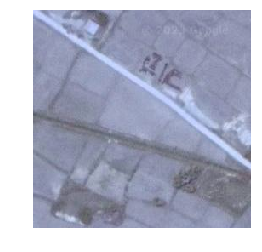

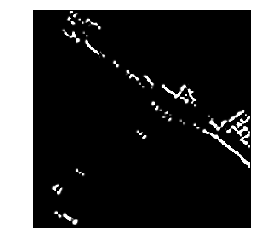

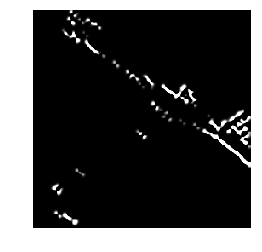

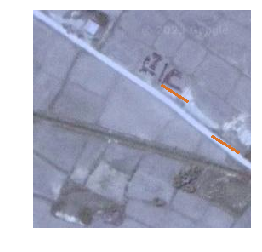

In [201]:
x = 189680 #203596-128762
y = 124144
print(Count_Wave(x,y,zoom=18,sensitivity=50,kernel_size=5,sobel_ksize=5,kernel_size_2=5,wv_length_thrshld_min=60))
plt.imshow(cv2.imread('images/'+str(x)+'-'+str(y)+'.png'))
plt.axis('off')
plt.show()
plt.imshow(cv2.imread('images/'+str(x)+'-'+str(y)+'_sobelxy.png'))
plt.axis('off')
plt.show()
plt.imshow(cv2.imread('images/'+str(x)+'-'+str(y)+'_sobelxy_blurred_twice.png'))
plt.axis('off')
plt.show()
plt.imshow(cv2.imread('images/'+str(x)+'-'+str(y)+'_result.png'))
plt.axis('off')
plt.show()

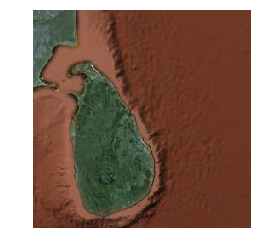

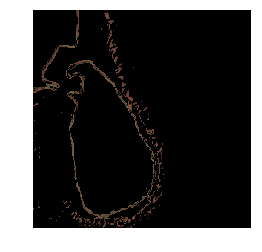

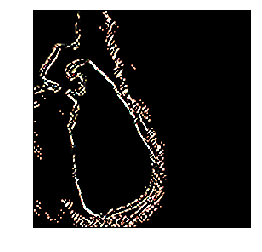

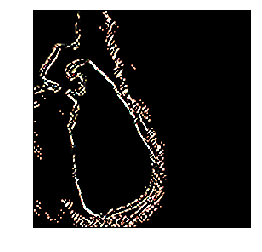

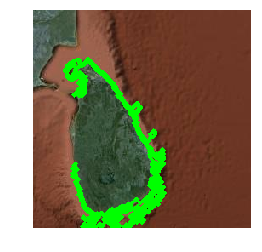

In [181]:
Get_Coast_Line(46,30,sensitivity=45,kernel_size=1,sobel_ksize=5,kernel_size_2=1)
plt.imshow(cv2.imread('images/'+str(46)+'-'+str(30)+'.png'))
plt.axis('off')
plt.show()
plt.imshow(cv2.imread('images/'+str(46)+'-'+str(30)+'_whitened.png'))
plt.axis('off')
plt.show()
plt.imshow(cv2.imread('images/'+str(46)+'-'+str(30)+'_sobelxy.png'))
plt.axis('off')
plt.show()
plt.imshow(cv2.imread('images/'+str(46)+'-'+str(30)+'_sobelxy_blurred_twice.png'))
plt.axis('off')
plt.show()
plt.imshow(cv2.imread('images/'+str(46)+'-'+str(30)+'_result.png'))
plt.axis('off')
plt.show()

In [242]:
gis_ls = []

Lat: 1.115258426839086
Long: 104.00903197481543
Eureka!
Eureka!
Eureka!
Eureka!
Eureka!
Eureka!
Eureka!
Eureka!
Eureka!
Eureka!
Eureka!
Eureka!
Eureka!
Eureka!
Eureka!
Eureka!


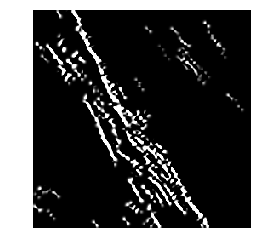

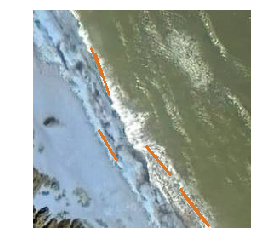

X: 190016; y:124480; Wave count: 6


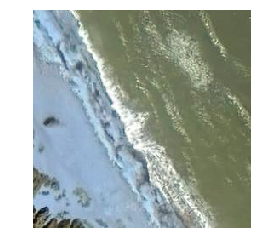

https://www.google.com/maps?z=16&t=k&q=9.015302333420598,80.947265625


In [243]:
i = 0
lat = input("Lat: ")
long = input("Long: ")
if lat == '' and long == '':
    input_latlong = (7.91257907803389, 80.5955504103782)
else:
    input_latlong = (float(lat), float(long))
(x_start , y_start) = latlong_to_ordinates_enlarged(input_latlong)
coast_lst = Get_Coast_Line(x_start , y_start,sensitivity=45,kernel_size=1,sobel_ksize=5,kernel_size_2=1)
while i < len(coast_lst):
    try:
        random_point_on_coast = coast_lst[i]
        i += 1
        random_latlong_on_coast = ordinates_to_latlong_enlarged((46+random_point_on_coast[0]/256,30+random_point_on_coast[0]/256))
        (x_r,y_r) = latlong_to_ordinates(random_latlong_on_coast)
        x_r,y_r
        gis_ls.append(Count_Wave(x_r,y_r,zoom=18,sensitivity=50,kernel_size=5,sobel_ksize=5,kernel_size_2=5,wv_length_thrshld_min=60))
    except Exception as e:
        pass
gis_ls = [dict(t) for t in {tuple(d.items()) for d in gis_ls}]
for gis in gis_ls:
    if gis['estimate'] == True:
        plt.imshow(cv2.imread('images/'+str(gis['x'])+'-'+str(gis['y'])+'_sobelxy_blurred_twice.png'))
        plt.axis('off')
        plt.show()
        
        plt.imshow(cv2.imread('images/'+str(gis['x'])+'-'+str(gis['y'])+'_result.png'))
        plt.axis('off')
        plt.show()
        
        print('X: '+str(gis['x'])+'; y:'+str(gis['y'])+'; Wave count: '+str(gis['wv_count']))
        plt.imshow(cv2.imread('images/'+str(gis['x'])+'-'+str(gis['y'])+'.png'))
        plt.axis('off')
        plt.show()
        
        lat,long = ordinates_to_latlong((gis['x'],gis['y']))
        print('https://www.google.com/maps?z=16&t=k&q='+str(lat)+','+str(long))

In [244]:
gis_ls

[{'x': 190016, 'y': 124480, 'wv_count': 6, 'estimate': True}]